Soit $A$ une matrice de $\mathcal{M}_{n,m}(\mathbb{K})$, avec $\mathbb{K}$ un corps (principalement $\mathbb{R}$ ici)

In [8]:
global A
A = [ [0, 0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1,1,0,0,1,0],[0,1,0,0,0,0,0,0,1,0],[0,1,1,1,1,1,1,1,1,0],
    [0,1,0,1,0,0,1,0,1,0],[0,1,0,0,0,0,0,0,1,0],[0,0,1,1,1,1,1,1,0,0],[0,0,0,1,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0,1,0] ]

def DisplayMat(A):
    for i in range(len(A)):
        print(A[i])  
#DisplayMat(A)

def creemat(n,m): #n liste de longueur m
    l=[]
    ml=[]
    for i in range(n):
        for j in range(m):
            ml.append(0)
        l.append(ml)
        ml=[]
    return l
#creemat(4,3)

def CopyMat(A):
    lignecopy=[]
    l=[]
    for i in range(len(A)):
        for j in A[i]:
            lignecopy.append(j)
        l.append(lignecopy)
        lignecopy=[]
    return l
#CopyMat(A)

Fonctions pour passer d'image $ppm$ ou $pgm$ ($P2$) vers une $matrice$, et réciproque

In [9]:
def MatToIm(nom,valeurmax,matrice):
    file = open(nom,"w")
    file.write("P2\n")
    n = len(matrice)
    m = len(matrice[0])
    file.write("%d %d\n" %(m,n)) # ecrire les dimensions
    file.write("%d\n" %valeurmax)
    for ligne in matrice:
        for k in ligne:
            file.write(str(k))
            file.write(" ")
        file.write("\n")
    file.close()
#MatToIm("PGM2Test.pgm",7,A)

def ImToMat(nom):
    file = open(nom,"r")
    file.readline() # sauter la première ligne
    
    ligne=file.readline() # lecture de la seconde ligne
    ligne=ligne.split(" ")
    nbligne = ligne[0] # nombre de lignes de l’image
    nbcol = ligne[1] # nombre de colonnes de l’image
    valeurmax = int(file.readline()) # valeur maximale pour le niveaux de gris
    
    matl=[]
    mat=[]
    for ligne in file.readlines(): #Construction de la matrice 
        ligne=ligne.split(" ")
        for i in range(len(ligne)-1):
            matl.append(int(ligne[i]))
        mat.append(matl)
        matl=[]

    return(mat,valeurmax)
#ImToMat("PGM2Test.pgm")

Espace de $Test$

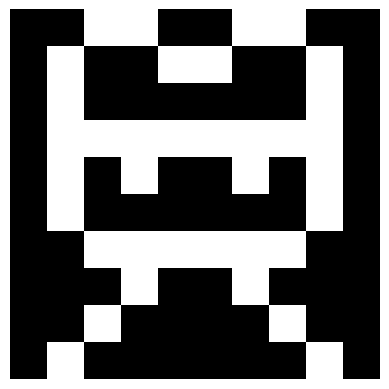

In [10]:
import matplotlib.pyplot as plt
plt.imshow(ImToMat("PGM2Test.pgm")[0],cmap=plt.get_cmap("gray")) # A est la matrice des pixels
plt.axis("off")
plt.show()

Fonctions additionnelles pour traiter des images grises

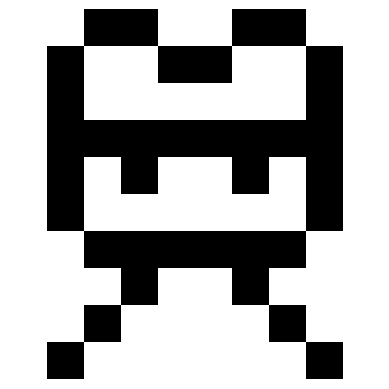

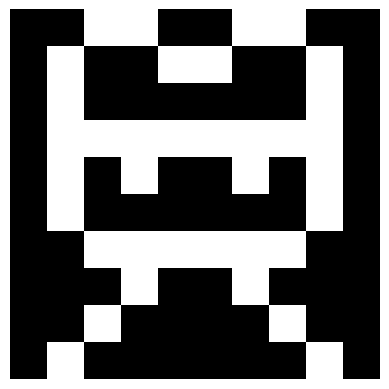

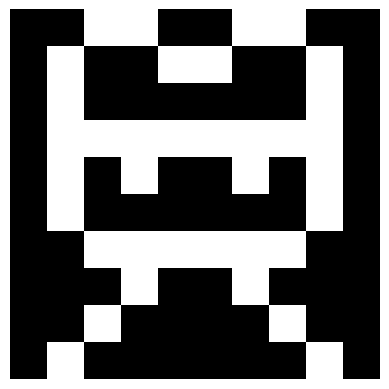

In [11]:
def inverser_gris(matrice,valeurmax):
    matl=[]
    mat=[]
    for i in range(len(matrice)):
        for j in range(len(matrice[i])):
            matl.append(valeurmax-matrice[i][j])
        mat.append(matl)
        matl=[]
    return (mat)
plt.imshow(inverser_gris(ImToMat("PGM2Test.pgm")[0],ImToMat("PGM2Test.pgm")[1]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

def Luminance(matrice):
    compteurP=0
    compteurV=0
    for i in range(len(matrice)):
        for j in range(len(matrice[i])):
            compteurP+=1
            compteurV=compteurV+matrice[i][j]
    return (compteurV/compteurP)
#print(Luminance(ImToMat("PGM2Test.pgm")[0]))

def estpair(mat):
    pair=False
    if len(mat)%2==0:
        pair=True
    return pair

def symetrie_verticale_gris(matrice):
    if estpair(matrice[0]):
        for z in range(len(matrice)):
            for i in range(0,len(matrice[0])//2,1):
                matrice[z][i],matrice[z][-(i+1)]=matrice[z][-(i+1)],matrice[z][i]
        return matrice
    else :
        for z in range(len(matrice)):
            for i in range(len(matrice)):
                matrice[z][i],matrice[z][-(i+1)]=matrice[z][-(i+1)],matrice[z][i]
        return matrice
        
        
plt.imshow((ImToMat("PGM2Test.pgm")[0]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

plt.imshow(symetrie_verticale_gris(ImToMat("PGM2Test.pgm")[0]),cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

Maintenant on applique nos fonctions précédentes directement sur des $PNG$ ou $JPEG$. $\\$
On commence par une fonction $convertir(A)$ pour une conversion de la forme $x \rightarrow \frac{x}{N}$ pour avoir des valeurs d'intensité de pixel dans $[0,1]$ en vue d'un calcul de gradien

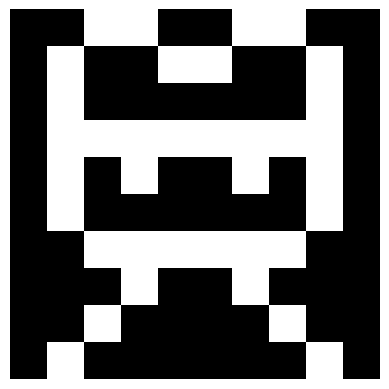

In [12]:
def convertir(A):
    maxi=0
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j]>maxi:
                maxi=A[i][j]
    N=maxi
    for i in range(len(A)):
        for j in range(len(A[i])):
            A[i][j]=A[i][j]/N
    return(A)

B=convertir(ImToMat("PGM2Test.pgm")[0])
plt.imshow(B,cmap="gray")
plt.axis("off")
plt.show()

# Gradien
$G_x(i,j)=(i+1,j)-(i-1,j) \\
G_y(i,j)=(i,j+1)-(i,j-1) \\$ Puis on garde $\sqrt{G_x^2(i,j)+G_y^2(i,j)} \\$
Optimisation : $G_x(i,j)=\frac{G_x(i,j)+G_x(i-1,j)+G_x(i+1,j)}{3}$ de même pour $G_y$

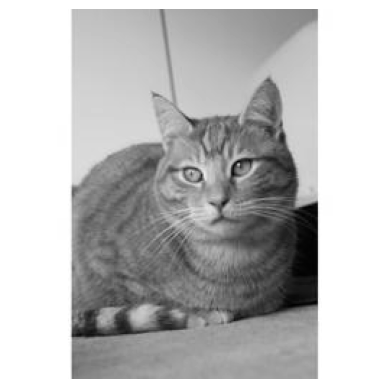

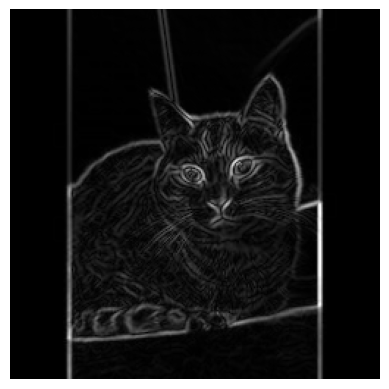

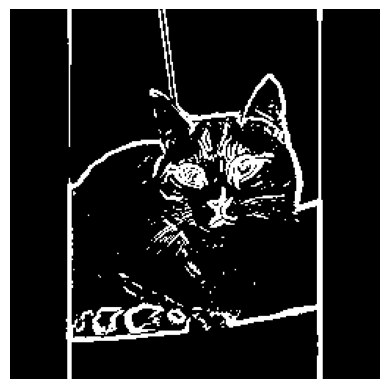

In [14]:
from PIL import Image
import numpy as np

img = Image.open("/Users/popov/Desktop/CatFinder/domestic cat/Image_73.jpg").convert("L")   # "L" = grayscale

def transmo(A):
    arr = np.array(A, dtype=np.float32)       # matrice de float
    mat=[]
    for i in arr:
        matl=[]
        for j in i:
            matl.append(j)
        mat.append(matl)
    return mat

import matplotlib.pyplot as plt
B=convertir(transmo(img))
plt.imshow(B , cmap="gray")
plt.axis("off")
plt.show()

def gradienOptimise(A):
    mat=[]
    maxgrad=0
    
    for i in range(2,len(A)-2):
        
        matl=[]
        
        for j in range(2,len(A[i])-2):
            
            Gx=((A[i+1][j]-A[i-1][j])+(-A[i-2][j])+(A[i+2][j]))/3
            Gy=((A[i][j+1]-A[i][j-1])+(-A[i][j-2])+(A[i][j+2]))/3
            grad=(Gx**2+Gy**2)**0.5
            matl.append(grad)
            
            
            if grad>maxgrad:
                maxgrad=grad
                
        mat.append(matl)
        
    return (mat,maxgrad)

B=convertir(gradienOptimise(transmo(img))[0])
plt.imshow(B, cmap="gray")
plt.axis("off")
plt.show()

def FiltreGrad(A):
    maxgrad=gradienOptimise(A)[1]
    mat=[]
    for i in range(0,len(A)):
        matl=[]
        for j in range(0,len(A[i])):
            if A[i][j]>maxgrad/4:
                matl.append(1)
            else : 
                matl.append(0)
                
        mat.append(matl)
    return mat


B=convertir(FiltreGrad(gradienOptimise(transmo(img))[0]))
plt.imshow(B, cmap="gray")
plt.axis("off")
plt.show()

MatToIm("PGM2Test.pgm",gradienOptimise(B)[1],B)